In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option('display.max_rows', None)

In [2]:
from collections import Counter
import arabic_reshaper 
from arabic_reshaper import reshape
from bidi.algorithm import get_display
from wordcloud import WordCloud, ImageColorGenerator
from langdetect import detect
from nltk.corpus import stopwords
import re
import nltk
from transformers import pipeline
from scipy.stats import zscore

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-23 22:35:41.401138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Videos

In [213]:
df_videos = pd.read_csv('Fetched-Data/video_stats.csv', index_col=0)
df_videos.head()

,video_id,title,description,publishedAt,categoryId,duration,channel_id,nb_comments,nb_views,nb_likes,defaultAudioLanguage,topicCategories,topics,del,date_published,time_published,duration_time,categories,Language
0,TaEuPHkfcS0,وثائقي | جرائم النازية - اختطاف الأطفال | وثائ...,عندما كانوا أطفالًا، اختطفهم النازيون من بولند...,2020-04-27T19:00:11Z,27,PT42M27S,UCET6sWl4Xcu-U8Ka9PJPrwA,613,531167,5466,ar,['https://en.wikipedia.org/wiki/Society'],['Society'],No,2020-04-27,19:00:11,00:42:27,Education,ar
1,ESN_wDg0DUo,Man found guilty in 30-year-old cold case invo...,Thirty years after single mother Barbara Brodk...,2023-02-25T15:17:49Z,25,PT1M58S,UCxUD8G1jO8T-Ef2tuADCZOA,15,7068,173,en-CA,['https://en.wikipedia.org/wiki/Society'],['Society'],No,2023-02-25,15:17:49,00:01:58,News & Politics,en-CA
2,7_8V-u9WJXY,Asi es como murieron estos asesinos seriales #...,NaN,2022-04-07T16:44:56Z,20,PT40S,UCJXiGyoWSDJhIJ1ztB0yChQ,2458,4983804,354463,NaN,NaN,NaN,NaN,2022-04-07,16:44:56,00:00:40,Gaming,es
3,2B4emTu7YUs,El POLICÍA ARGENTINO que ASESlNÒ a su ESPOSA y...,¡Hola a todos! \nMi nombre es María y cada sem...,2024-05-13T20:34:27Z,25,PT22M10S,UCK_-_4AP8QCJLuoVG8mxPMA,97,56634,3171,es,['https://en.wikipedia.org/wiki/Society'],['Society'],No,2024-05-13,20:34:27,00:22:10,News & Politics,es
4,-ETWNxemJWk,Encore une agression verbale...,Voilà ce qu'il s'est passé vendredi dernier. E...,2024-05-27T08:28:49Z,22,PT1M41S,UCYYIOXsDpE2Zy2rjOClx6nA,0,7,1,NaN,['https://en.wikipedia.org/wiki/Society'],['Society'],No,2024-05-27,08:28:49,00:01:41,People & Blogs,fr


In [214]:
df_video = df_videos.drop(['categoryId','duration','defaultAudioLanguage','topicCategories','del'], axis=1)
df_video.columns

Index(['video_id', 'title', 'description', 'publishedAt', 'channel_id',
       'nb_comments', 'nb_views', 'nb_likes', 'topics', 'date_published',
       'time_published', 'duration_time', 'categories', 'Language'],
      dtype='object')

In [215]:
df_video.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2707 entries, 0 to 2706
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        2707 non-null   object
 1   title           2707 non-null   object
 2   description     2502 non-null   object
 3   publishedAt     2707 non-null   object
 4   channel_id      2707 non-null   object
 5   nb_comments     2707 non-null   int64 
 6   nb_views        2707 non-null   int64 
 7   nb_likes        2707 non-null   int64 
 8   topics          2508 non-null   object
 9   date_published  2707 non-null   object
 10  time_published  2707 non-null   object
 11  duration_time   2707 non-null   object
 12  categories      2688 non-null   object
 13  Language        2707 non-null   object
dtypes: int64(3), object(11)
memory usage: 317.2+ KB


In [217]:
df_video.describe()

,nb_comments,nb_views,nb_likes
count,2707.000000,2.707000e+03,2.707000e+03
mean,520.299224,6.132304e+05,9.781888e+03
std,1691.668924,2.550501e+06,4.336908e+04
min,0.000000,0.000000e+00,0.000000e+00
25%,5.000000,6.834000e+03,8.200000e+01
50%,54.000000,3.818600e+04,6.000000e+02
75%,294.500000,2.225940e+05,3.946500e+03
max,35012.000000,4.453565e+07,1.167024e+06


**Convert types**

In [242]:
# Convert publish date to datetime
df_video['publishedAt'] = pd.to_datetime(df_video['publishedAt'])

**Clean the Language column**

In [243]:
df_video['Language'] = (
    df_video['Language']
    .str.split('-')
    .str[0]  # Get the part before the hyphen
    .str.lower()  # Convert to lowercase
)

**Views and Likes Analysis**

 Investigate how the number of likes correlates with the number of views

Text(0.5, 1.0, 'Video Likes vs. Video Views')

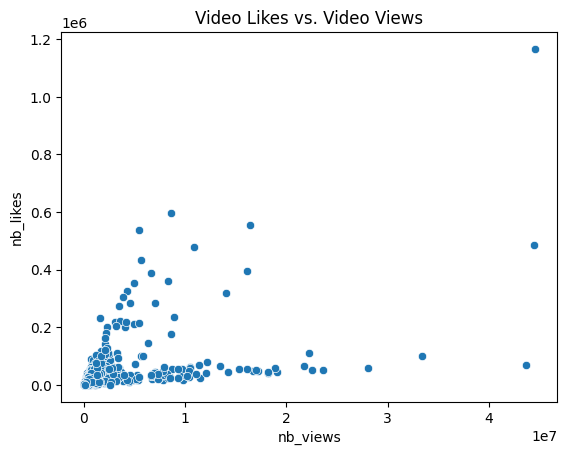

In [222]:
sns.scatterplot(data=df_video, x='nb_views', y='nb_likes')
plt.title('Video Likes vs. Video Views')


**Comments Analysis**

Analyze how the number of comments varies with views and likes

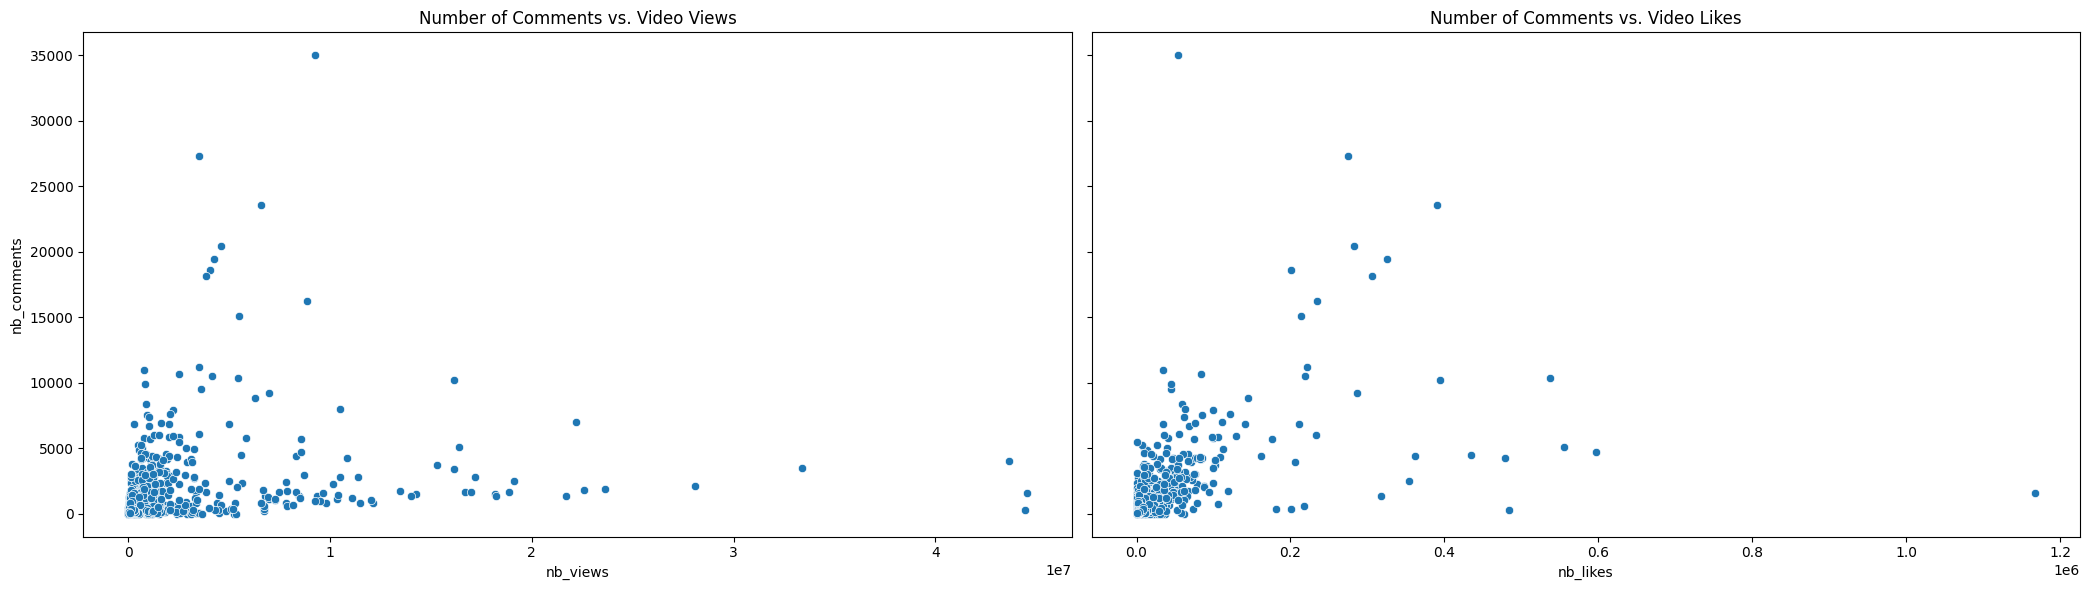

In [227]:
# Create subplots - 1 column, 3 rows
fig, axes = plt.subplots(1, 2, figsize=(21, 6), sharey=True)

sns.scatterplot(ax=axes[0], data=df_video, x='nb_views', y='nb_comments')
axes[0].set_title('Number of Comments vs. Video Views')

sns.scatterplot(ax=axes[1], data=df_video, x='nb_likes', y='nb_comments')
axes[1].set_title('Number of Comments vs. Video Likes')

# Adjust layout
plt.tight_layout()
plt.show()



**Temporal Analysis**

Video Upload Trends: Analyze the trend of video uploads over time.

/var/folders/v3/vzv7hgws4w50m44vnrtb6py80000gn/T/ipykernel_4427/561399272.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_trends = df_video.resample('Y', on='publishedAt').size()


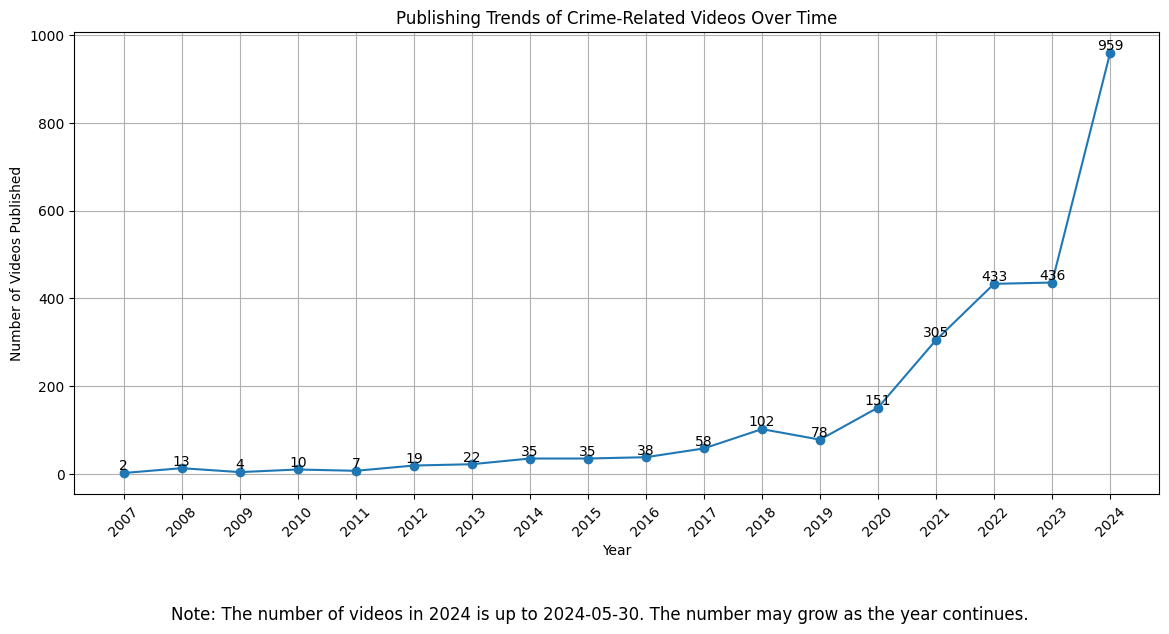

In [235]:
# Group by month and count number of videos
yearly_trends = df_video.resample('Y', on='publishedAt').size()

# Find the last date in the DataFrame
last_date = df_video['publishedAt'].max()

# Create the comment about 2024
comment = f"Note: The number of videos in 2024 is up to {last_date.date()}. The number may grow as the year continues."

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(yearly_trends.index.year, yearly_trends.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Videos Published')
plt.title('Publishing Trends of Crime-Related Videos Over Time')
plt.grid(True)
plt.xticks(yearly_trends.index.year, rotation=45)

# Add values on the plot
for x, y in zip(yearly_trends.index.year, yearly_trends.values):
    plt.text(x, y, str(y), ha='center', va='bottom')

# Add the comment to the plot
plt.figtext(0.5, -0.1, comment, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()


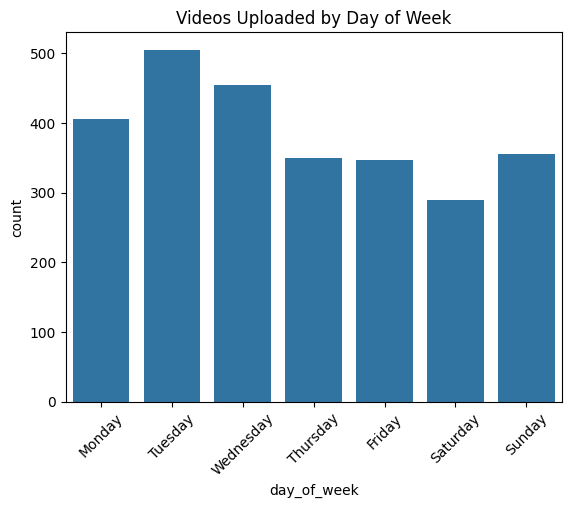

In [233]:
df_video['day_of_week'] = df_video['publishedAt'].dt.day_name()
sns.countplot(data=df_video, x='day_of_week', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Videos Uploaded by Day of Week')
plt.xticks(rotation=45)
plt.show()


**Language Preferences**

Analyze how video language correlates with number videos, views, comments, and likes.

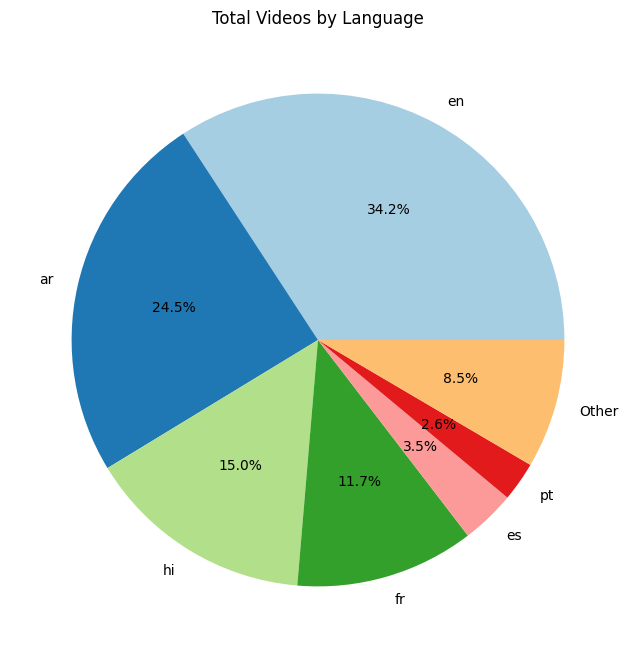

In [244]:
# Count of languages used by channels
language_counts_vid = df_video['Language'].value_counts()

# Select the top 10 languages
top_languages_vid = language_counts_vid[:6]

# Group the rest into 'Other'
top_languages_vid['Other'] = language_counts_vid[6:].sum()

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(top_languages_vid, labels=top_languages_vid.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Total Videos by Language')
plt.show()


/var/folders/v3/vzv7hgws4w50m44vnrtb6py80000gn/T/ipykernel_4427/1855242672.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/v3/vzv7hgws4w50m44vnrtb6py80000gn/T/ipykernel_4427/1855242672.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/v3/vzv7hgws4w50m44vnrtb6py80000gn/T/ipykernel_4427/1855242672.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


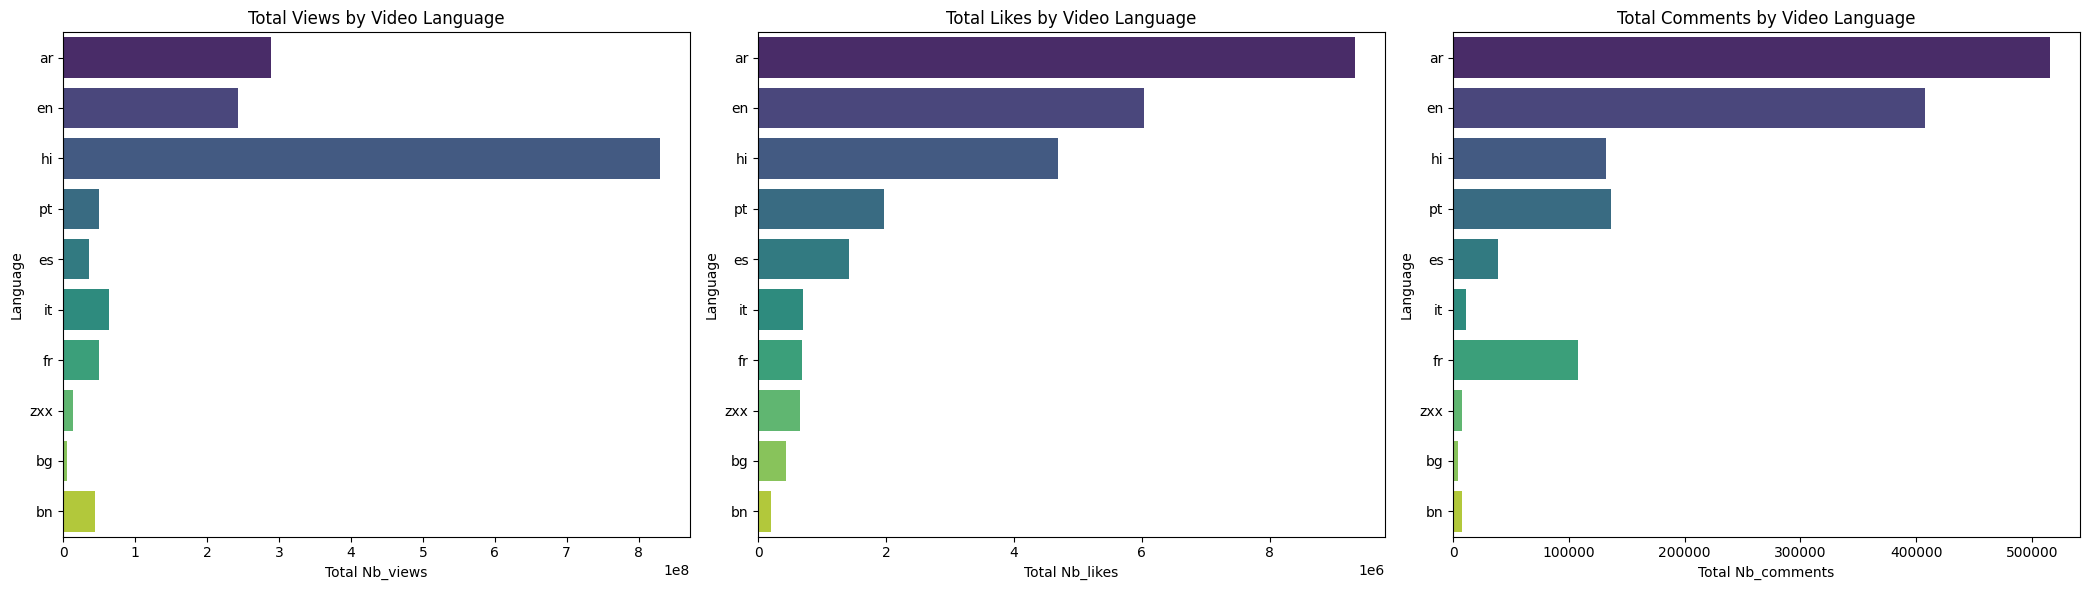

In [248]:
# Group by language and calculate total engagement metrics
language_metrics = df_video.groupby('Language').agg({
    'nb_views': 'sum',
    'nb_likes': 'sum',
    'nb_comments': 'sum'
}).reset_index()

language_metrics = language_metrics.sort_values('nb_likes', ascending=False)[:10]

# Reshape the data to a long format for better plotting with Seaborn
language_metrics_long = pd.melt(
    language_metrics, 
    id_vars=['Language'], 
    value_vars=['nb_views', 'nb_likes', 'nb_comments'],
    var_name='Metric', 
    value_name='Total Value'
)

fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharex=False)

# Define the metrics to plot
metrics = ['nb_views', 'nb_likes', 'nb_comments']
titles = ['Total Views by Video Language', 'Total Likes by Video Language', 'Total Comments by Video Language']

# Plot each metric separately
for i, metric in enumerate(metrics):
    sns.barplot(
        ax=axes[i],
        x='Total Value', 
        y='Language', 
        data=language_metrics_long[language_metrics_long['Metric'] == metric],
        palette='viridis'
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Total ' + metric.capitalize())
    axes[i].set_ylabel('Language')

# Adjust layout
plt.tight_layout()
plt.show()

**Keyword and Tag Analysis**

Identifying common keywords, tags, or phrases used in titles. Visualizing with word clouds.

In [249]:
font_file = 'arabic_process/DejaVuSans.ttf'
path_ar = "arabic_process/arabic_dialects_stopwords.csv"

# Function to detect language safely
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'
    
# Detect language of each title
df_video['lang_title'] = df_video['title'].apply(lambda x: detect_language(x))


# Download stopwords from NLTK 
nltk.download('stopwords')

# Load predefined stopwords
stopwords_en = set(stopwords.words('english'))
stopwords_fr = set(stopwords.words('french'))

# Load Arabic stopwords from your file (assuming one word per line)
with open(path_ar, 'r', encoding='utf-8') as f:
    stopwords_ar = set([line.strip() for line in f])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Function to preprocess text based on language
def preprocess_text(text, lang):
    # Define stopwords for each language
    stopwords_dict = {
        'en': stopwords_en,
        'fr': stopwords_fr,
        'ar': stopwords_ar,
    }

    # Remove punctuation, numbers, and normalize text
    cleaned_text = re.sub(r'[^A-Za-z\u0600-\u06FF\s]', '', text)

    # Remove stopwords specific to language
    words = cleaned_text.lower().split()
    filtered_words = [word for word in words if word not in stopwords_dict.get(lang, set())]

    # If Arabic, reshape and apply bidi algorithm
    if lang == 'ar':
        reshaped_text = reshape(' '.join(filtered_words))
        return get_display(reshaped_text)
    else:
        return ' '.join(filtered_words)

# Preprocess titles based on detected language
df_video['processed_title'] = df_video.apply(lambda row: preprocess_text(row['title'], row['lang_title']), axis=1)

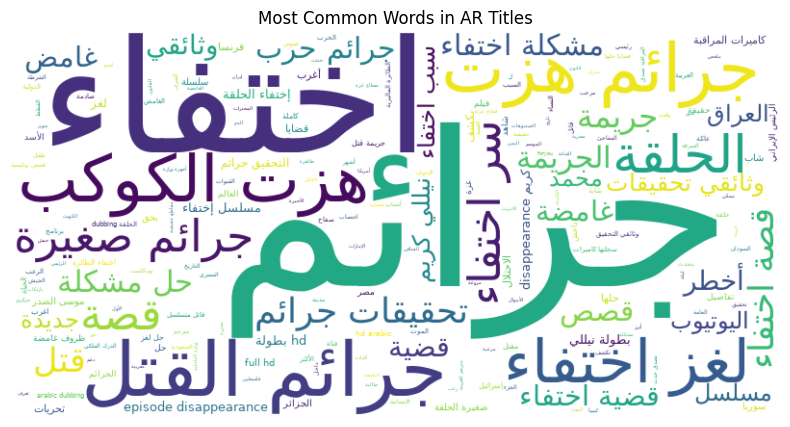

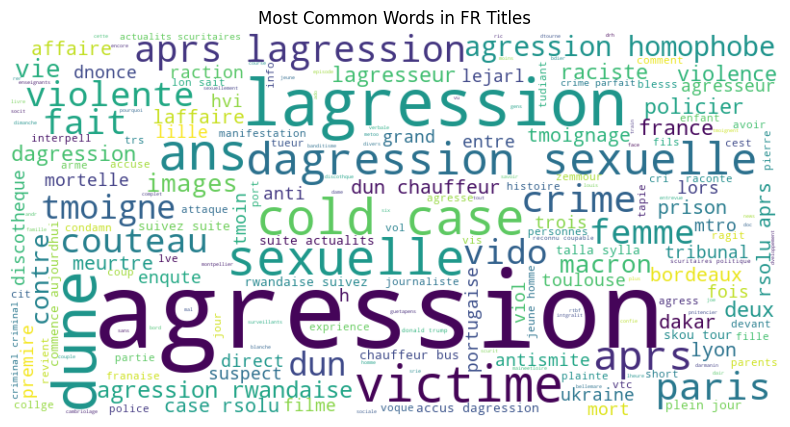

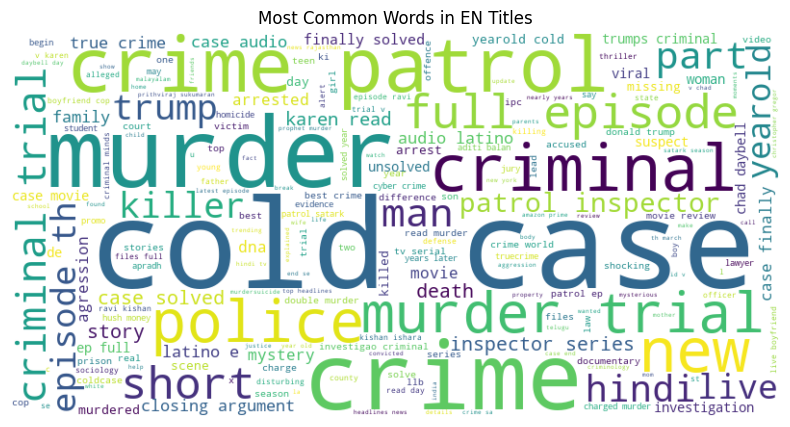

In [31]:
# Separate DataFrames by language
languages = ['ar','fr','en']

# Visualize word clouds for each language
for lang in languages:

    lang_df = df_video[df_video['lang_title'] == lang]
    all_titles = ' '.join(lang_df['processed_title'].dropna().tolist())

    # Generate and plot word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        font_path=font_file if lang == 'ar' else None  # Adjust font for Arabic if needed
    ).generate(all_titles)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Common Words in {lang.upper()} Titles')
    plt.show()

**Calculate z-scores for the view count to identify outliers**

In [95]:
df_video['view_zscore'] = zscore(df_video['nb_views'])
# Identify outliers where z-score is beyond a typical threshold, e.g., > 3 or < -3
outliers = df_video[(df_video['view_zscore'] > 3) | (df_video['view_zscore'] < -3)]
outliers[['title', 'nb_views', 'view_zscore']].head()


,title,nb_views,view_zscore
70,Crime Patrol - क्राइम पेट्रोल सतर्क - Episode ...,9790867,3.599031
77,They found a Potential Murder Hideout.. #crime...,10819506,4.002414
187,Intervista a un boss di camorra - Kings of Cri...,8698541,3.170673
194,Crime Patrol - क्राइम पेट्रोल सतर्क - Taxi - E...,10353319,3.819598
210,Crime Petrol,44445392,17.188882
278,Crime Patrol - क्राइम पेट्रोल सतर्क - Asambhav...,19106268,7.252087
300,Crime Patrol Dial 100 - Ep 766 - Full Episode ...,13454850,5.035870
378,Crime Patrol Dial 100 - क्राइम पेट्रोल- Ep 414...,18865378,7.157621
535,Crime Patrol - क्राइम पेट्रोल सतर्क - Dahleez ...,23630079,9.026110
622,Crime Patrol - क्राइम पेट्रोल सतर्क - Ep 792- ...,8467761,3.080172


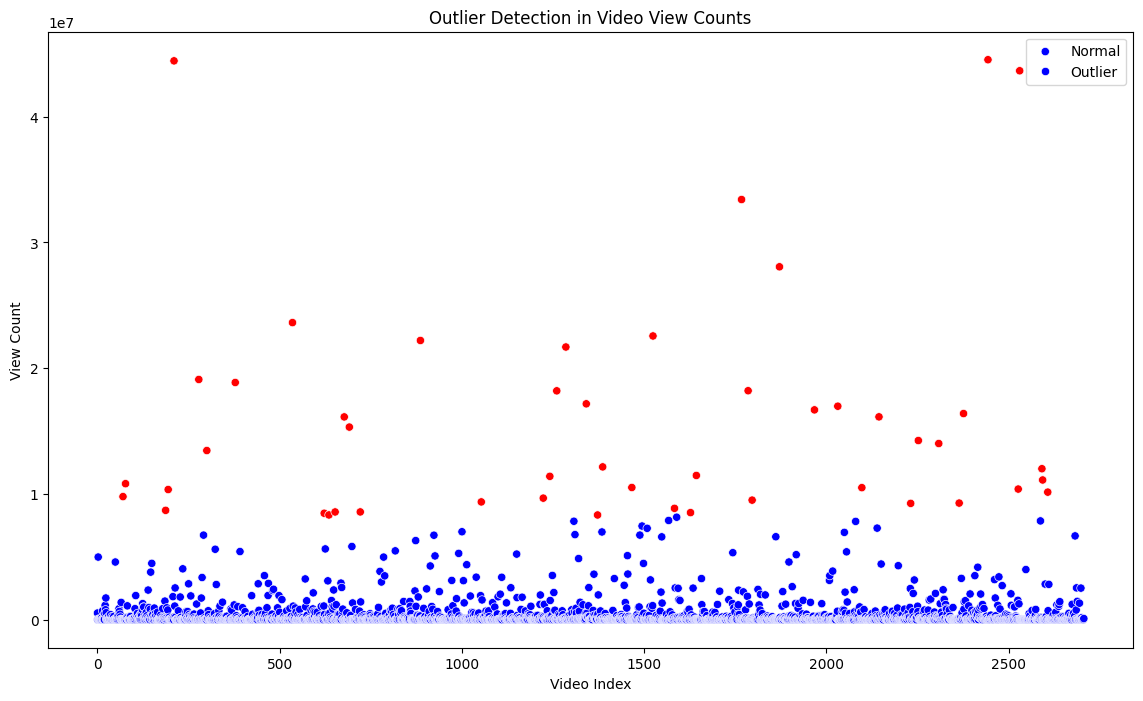

In [100]:
# Scatter plot to visualize outliers
plt.figure(figsize=(14, 8))
sns.scatterplot(x=range(len(df_video)), y='nb_views', data=df_video, hue=(df_video['view_zscore'].abs() > 3), palette={True: 'red', False: 'blue'})
plt.xlabel('Video Index')
plt.ylabel('View Count')
plt.title('Outlier Detection in Video View Counts')
plt.legend(['Normal', 'Outlier'])
plt.show()
